### Making Predictions Using Pre-trained Networks
**Transfer learning is an approach in deep learning (and machine learning) where knowledge is transferred from one model to another.**

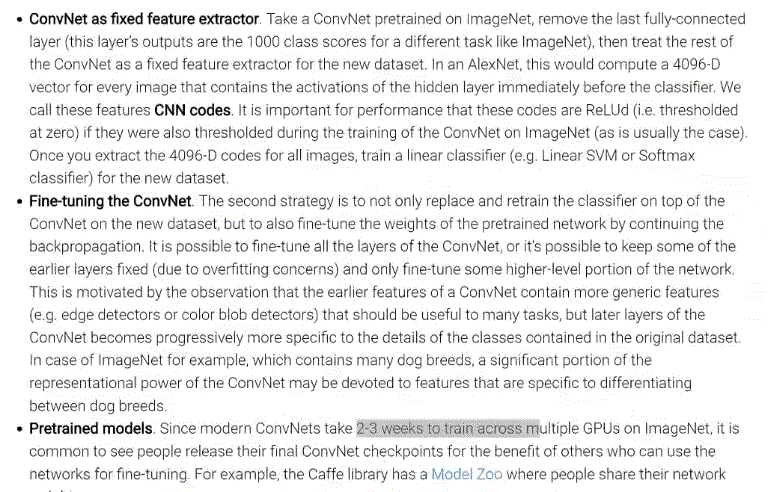
- **Finetunning** : 
        - Suppose we have Convolutional base + classifier, Let say in Convolutional Base there is a layer with some weight and you want to update a bit that weight such that update may lead to better accuracy, this is called fine tunning.  
        - It can done on entire Convolutional Base, but in general we only do it for some higher-level portion of the network (like last three layers of base) because lower level layer are more generic because they extract edges, pattern, texture etc.. but higher level learns how different parts of image is combined.
        - Important thing to note here is:
            - We should keep smaller Learning Rate while fine tunning, because at the time of weights update large LR can destory the weigths which have been learned earlier, we freeze the lower level layers and then fine tune the higher level layers.
            - Fine tunning is not done on smaller datasets it may lead to overfitting.

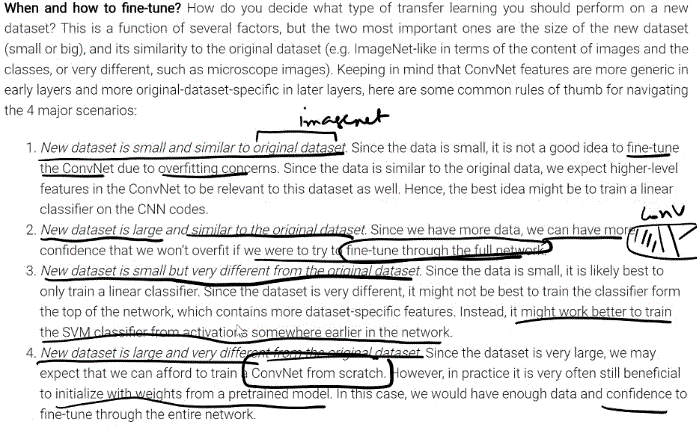

In [19]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

In [20]:
# model = ResNet50(weights = 'imagenet')

In [21]:
# img_path = 'elephant.jpg'
# img = image.load_img(img_path, target_size = (224,224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis = 0)
# x = preprocess_input(x)
# # decode the results into a list of tuples(Class, description, probablity)
# # one such list for each sample in the batch
# preds =  model.predict(x)
# print('Predicted', decode_predictions(preds, top =3)[0])

Predicted [('n02504458', 'African_elephant', 0.778717), ('n01871265', 'tusker', 0.12713975), ('n02504013', 'Indian_elephant', 0.09208994)]


### Performing Finetunning On Animal Dataset

In [22]:
import os
folders = os.listdir('images')
folders

['cats', 'dogs', 'horses', 'humans']

In [23]:
image_data = []
labels = []
label_dict = {
    'cats': 0,
    'dogs':1,
    'horses':2,
    'humans':3
}

In [24]:
for ix in folders:
    path = os.path.join('image', ix)
    print(path)

image\cats
image\dogs
image\horses
image\humans


In [29]:
for ix in folders:
    path = os.path.join('images',ix)
    for i in os.listdir(path):
        img = image.load_img(os.path.join(path,i), target_size = ((224,224)))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(label_dict[ix])

In [30]:
print(len(image_data), len(labels))

809 808


In [34]:
import random
combined = list(zip(image_data,labels))
random.shuffle(combined)
image_data[:], labels[:] = zip(*combined)

In [50]:
b = np.array(labels)
print(b[:5])
np.unique(b) # four categories 

[2 0 1 1 1]


array([0, 1, 2, 3])

In [51]:
print(labels[:5])

[2, 0, 1, 1, 1]


In [52]:
X_train = np.array(image_data)
Y_train = np.array(labels)

print(X_train.shape, Y_train.shape)

(808, 224, 224, 3) (808,)


In [53]:
from keras.utils import np_utils

In [54]:
# Convert Y_train into One Hot Labels as we are using MLP at the end
Y_train = np_utils.to_categorical(Y_train)
print(Y_train)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


In [56]:
# create the model resnet 50 models
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import *
from keras.models import Model
import matplotlib.pyplot as plt

In [58]:
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = (224,244,3))
# include_top: whether to include the fully-connected layer at the top of the network.
# weights: one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.

94773248/94765736 [==============================] - 108s 1us/step


In [59]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 244, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 250, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 122, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 122, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [60]:
# Total params: 23,587,712
# Trainable params: 23,534,592
# Non-trainable params: 53,120
# 23,587,712 which may overfit over our 800 images


In [66]:
av1 = GlobalAveragePooling2D()(model.output)
fc1 = Dense(256, activation = 'relu')(av1) #(av1) is input the dense layer
d1 = Dropout(0.5)(fc1)
fc2 = Dense(4, activation = 'softmax')(d1)

model_new = Model(inputs = model.input, outputs = fc2) # functional API of Keras
model_new.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 244, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 250, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 122, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 122, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [67]:
adam = Adam(lr = 0.0003)
model_new.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [70]:
for ix in range(len(model_new.layers)):
    print(ix, model_new.layers[ix]) # index and layer

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001FC3A8F2FA0>
1 <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001FC3B47DE50>
2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001FC3B49D400>
3 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001FC3A8F2D60>
4 <tensorflow.python.keras.layers.core.Activation object at 0x000001FC3B49D0D0>
5 <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001FC1A32CE50>
6 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001FC1A32CE20>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001FC3B4BDB80>
8 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001FC3B4B72B0>
9 <tensorflow.python.keras.layers.core.Activation object at 0x000001FC3B4EC460>
10 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001FC3B4ECA00>
11 <tensorflow.python.keras.

In [73]:
# We will fine tune from 169 to 174,
# but we need to set all <169 as non trainable
for ix in range(169):
    model_new.layers[ix].trainable = False
model_new.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
model_new.summary() # now lesser no. of trainable parameters

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 244, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 250, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 122, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 122, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [74]:
hist = model_new.fit(
                    X_train,Y_train,
                    shuffle = True,
                    batch_size = 16,
                    epochs = 5,
                    validation_split = 0.20
                    )

Epoch 1/5
41/41 [==============================] - 51s 1s/step - loss: 0.4513 - accuracy: 0.8452 - val_loss: 0.2393 - val_accuracy: 0.9444
Epoch 2/5
41/41 [==============================] - 56s 1s/step - loss: 0.0894 - accuracy: 0.9737 - val_loss: 0.1678 - val_accuracy: 0.9444
Epoch 3/5
41/41 [==============================] - 71s 2s/step - loss: 0.0556 - accuracy: 0.9830 - val_loss: 0.1707 - val_accuracy: 0.9568
Epoch 4/5
41/41 [==============================] - 69s 2s/step - loss: 0.0298 - accuracy: 0.9907 - val_loss: 0.1609 - val_accuracy: 0.9506
Epoch 5/5
41/41 [==============================] - 66s 2s/step - loss: 0.0152 - accuracy: 0.9938 - val_loss: 0.1803 - val_accuracy: 0.9506
